In [51]:
import pandas as pd
from itertools import cycle
import gpflow
import numpy as np
from gpflow.utilities import print_summary, positive
from gpflow.ci_utils import ci_niter
from gpflow.optimizers import NaturalGradient
from gpflow import set_trainable
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

tfd = tfp.distributions

np.random.seed(1234)

sns.set(style="white")

In [2]:
print("The GPflow version is {0}".format(gpflow.__version__))
print("The tensorflow version is {0}".format(tf.__version__))
print("The tensorflow-probability version is {0}".format(tfp.__version__))

The GPflow version is 2.0.5
The tensorflow version is 2.2.0
The tensorflow-probability version is 0.10.0


## Load Datasets UK

Load the Google Mobility report [link](https://www.google.com/covid19/mobility/https://www.google.com/covid19/mobility/) and the COVID data from the UK government webiste [link](https://coronavirus.data.gov.uk). 

In [3]:
covid_cases = pd.read_csv("./Data/Daily COVID Cases/ONS_Daily_COVID_JULY.csv")
covid_cases["Date"] = pd.to_datetime(covid_cases["Date"], format='%d/%m/%Y')
mobility_data = pd.read_csv("./Data/Google/Global_Mobility_Report.csv", encoding = "ISO-8859-1")
mobility_data["date"] = pd.to_datetime(mobility_data["date"], format='%d/%m/%Y')

/Users/georgiospapadopoulos/opt/anaconda3/envs/argos/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# UK
mobility_data_uk = mobility_data[(mobility_data.country_region=="United Kingdom") & (mobility_data.sub_region_1.isnull())]
mobility_data_uk = mobility_data_uk.iloc[:,7:].reset_index(drop=True) # keep only relevant columns
mobility_data_uk.columns

Index(['date', 'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline'],
      dtype='object')

In [5]:
# transform the data to pct change
mobility_data_uk[mobility_data_uk.columns[1:]] = mobility_data_uk[mobility_data_uk.columns[1:]].apply(lambda x: x/100 + 1)

In [6]:
data_uk = pd.DataFrame(mobility_data_uk["date"])

In [7]:
data_uk["HOME"] = mobility_data_uk['residential_percent_change_from_baseline'].copy()
data_uk["WORK"] = mobility_data_uk['workplaces_percent_change_from_baseline'].copy()
data_uk["OTHER"] = mobility_data_uk.iloc[:,1:5].mean(axis=1)

In [8]:
# Add weekend/weekdays class in UK data
data_uk["WEEKDAY"] = 0
data_uk.loc[data_uk.date.dt.dayofweek < 5, "WEEKDAY"] = 1
data_uk["WEEKDAY"] = data_uk["WEEKDAY"].astype("category")

In [9]:
data_uk

,date,HOME,WORK,OTHER,WEEKDAY
0,2020-02-15,1.02,0.96,0.8350,0
1,2020-02-16,1.01,0.97,0.8800,0
2,2020-02-17,1.02,0.86,1.0825,1
3,2020-02-18,1.02,0.86,1.0575,1
4,2020-02-19,1.03,0.86,1.0200,1
...,...,...,...,...,...
159,2020-07-23,1.14,0.53,0.9925,1
160,2020-07-24,1.13,0.54,1.0275,1
161,2020-07-25,1.06,0.85,0.8300,0
162,2020-07-26,1.03,0.91,0.9950,0


In [10]:
covid_cases.drop(["Change", "Previously reported"], axis=1, inplace=True)

In [14]:
covid_cases = covid_cases[:-1].copy()

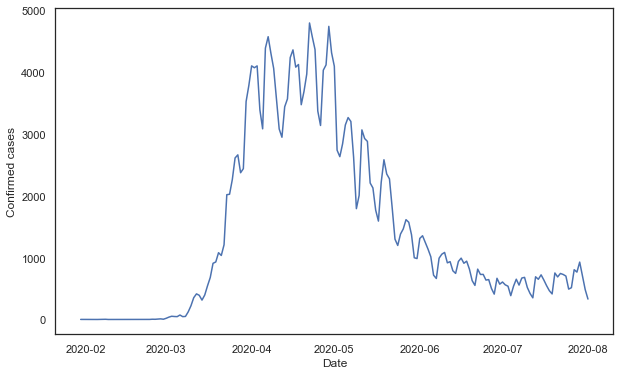

In [15]:
plt.figure(figsize=(10,6))
sns.lineplot(x="Date", y="Confirmed cases", data=covid_cases)

In [16]:
# merge sets
final_data_uk = covid_cases.merge(data_uk, how='left', left_on='Date', right_on='date') 

In [17]:
final_data_uk

,Date,Confirmed cases,date,HOME,WORK,OTHER,WEEKDAY
0,2020-01-30,2,NaT,NaN,NaN,NaN,NaN
1,2020-02-03,1,NaT,NaN,NaN,NaN,NaN
2,2020-02-05,1,NaT,NaN,NaN,NaN,NaN
3,2020-02-08,4,NaT,NaN,NaN,NaN,NaN
4,2020-02-09,1,NaT,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
162,2020-07-28,767,NaT,NaN,NaN,NaN,NaN
163,2020-07-29,929,NaT,NaN,NaN,NaN,NaN
164,2020-07-30,705,NaT,NaN,NaN,NaN,NaN
165,2020-07-31,484,NaT,NaN,NaN,NaN,NaN


In [19]:
final_data_uk["Confirmed cases"] = final_data_uk["Confirmed cases"].astype("float64")
final_data_uk["WEEKDAY"] = final_data_uk["WEEKDAY"].astype("float64")
final_data_uk.dtypes

Date               datetime64[ns]
Confirmed cases           float64
date               datetime64[ns]
HOME                      float64
WORK                      float64
OTHER                     float64
WEEKDAY                   float64
dtype: object

In [20]:
final_data_uk.dropna(axis=0, inplace=True)
final_data_uk["Date_number"] = final_data_uk.Date.dt.dayofyear - 50
final_data_uk["Date_number"] = final_data_uk["Date_number"].astype("float64")
final_data_uk = final_data_uk.drop(["date"], axis=1).reset_index(drop=True)
final_data_uk

,Date,Confirmed cases,HOME,WORK,OTHER,WEEKDAY,Date_number
0,2020-02-21,1.0,1.03,0.85,1.0275,1.0,2.0
1,2020-02-24,2.0,1.01,0.98,0.9625,1.0,5.0
2,2020-02-25,5.0,1.00,1.01,1.0175,1.0,6.0
3,2020-02-26,4.0,1.00,1.01,1.0150,1.0,7.0
4,2020-02-27,7.0,1.00,1.00,1.0275,1.0,8.0
...,...,...,...,...,...,...,...
151,2020-07-23,729.0,1.14,0.53,0.9925,1.0,155.0
152,2020-07-24,703.0,1.13,0.54,1.0275,1.0,156.0
153,2020-07-25,492.0,1.06,0.85,0.8300,0.0,157.0
154,2020-07-26,515.0,1.03,0.91,0.9950,0.0,158.0


In [21]:
# Create a combination of mixing matrices the same way they do in literature. 
# Fill NA values with 0

C_HOME = pd.read_csv("./Data/BBC/HOME.csv", index_col=0)

C_WORK = pd.read_csv("./Data/BBC/WORK.csv", index_col=0)

C_OTHER = pd.read_csv("./Data/BBC/OTHER.csv", index_col=0)

C = C_HOME + C_WORK + C_OTHER

C.fillna(0, inplace=True)

# Visual Exploration

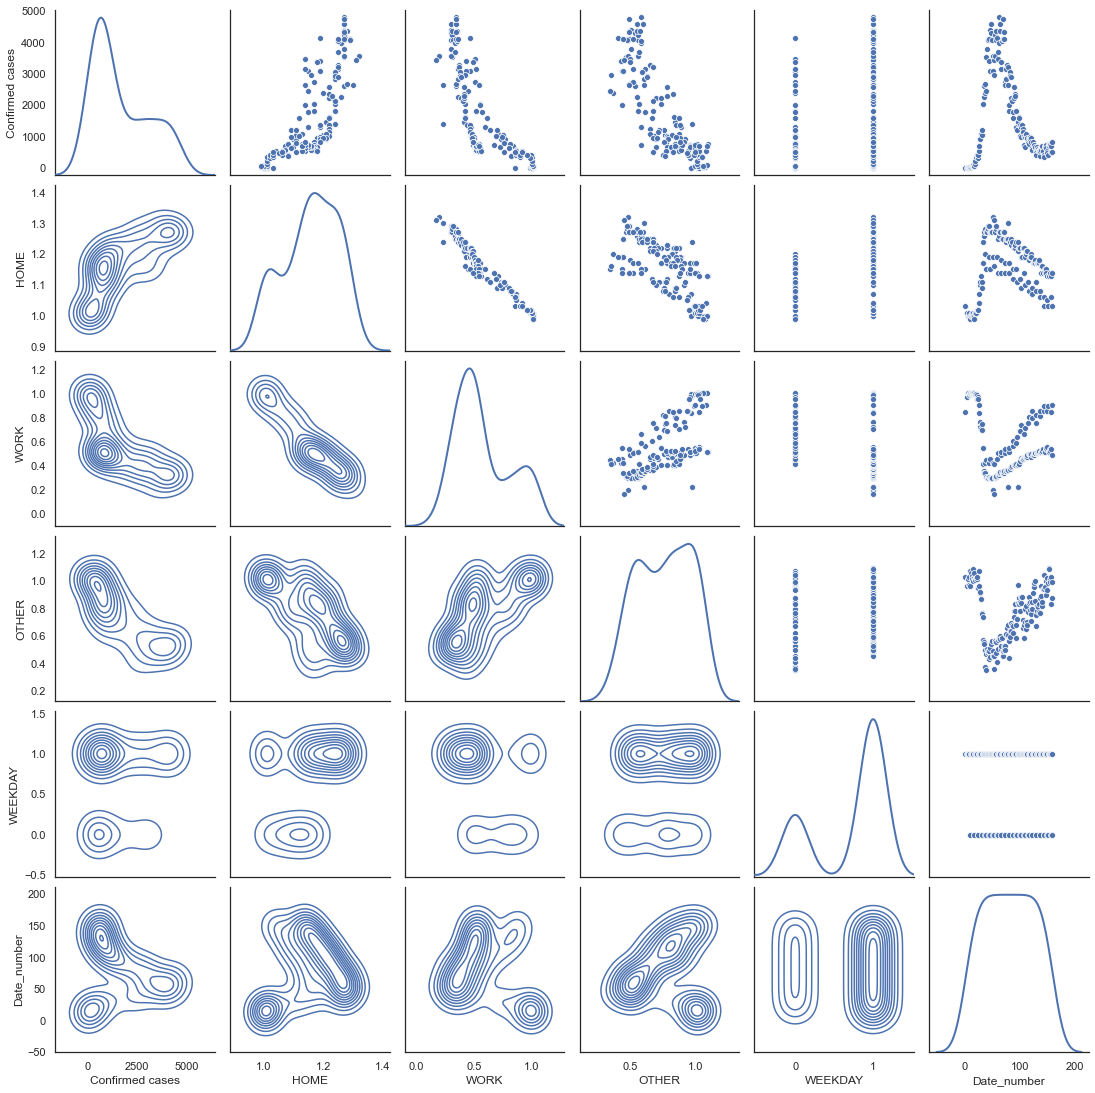

In [23]:
g = sns.PairGrid(final_data_uk, diag_sharey=False)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot, colors="C0")
g.map_diag(sns.kdeplot, lw=2)

In [24]:
final_data_uk.corr()

,Confirmed cases,HOME,WORK,OTHER,WEEKDAY,Date_number
Confirmed cases,1.000000,0.796631,-0.764248,-0.834095,0.134402,-0.236976
HOME,0.796631,1.000000,-0.973893,-0.724510,0.409226,0.135643
WORK,-0.764248,-0.973893,1.000000,0.697917,-0.369386,-0.216031
OTHER,-0.834095,-0.724510,0.697917,1.000000,0.140740,0.165146
WEEKDAY,0.134402,0.409226,-0.369386,0.140740,1.000000,-0.034957
Date_number,-0.236976,0.135643,-0.216031,0.165146,-0.034957,1.000000


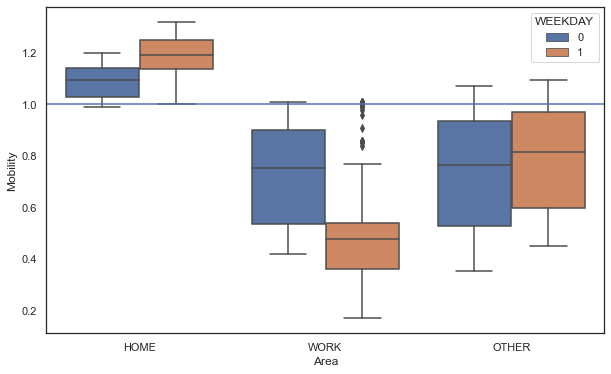

In [25]:
# Plot the average mobility value by area and weekday/weekend
data_melt = pd.melt(data_uk.iloc[:,1:4], var_name='Area', value_name='Mobility')
seq = cycle(data_uk["WEEKDAY"])
data_melt['WEEKDAY'] = [next(seq) for count in range(data_melt.shape[0])]

plt.figure(figsize=(10,6))
sns.boxplot(x="Area", y="Mobility", hue="WEEKDAY", data=data_melt)
plt.axhline(y=1.0)

## Model 1

In [27]:
final_data_uk

,Date,Confirmed cases,HOME,WORK,OTHER,WEEKDAY,Date_number
0,2020-02-21,1.0,1.03,0.85,1.0275,1.0,2.0
1,2020-02-24,2.0,1.01,0.98,0.9625,1.0,5.0
2,2020-02-25,5.0,1.00,1.01,1.0175,1.0,6.0
3,2020-02-26,4.0,1.00,1.01,1.0150,1.0,7.0
4,2020-02-27,7.0,1.00,1.00,1.0275,1.0,8.0
...,...,...,...,...,...,...,...
151,2020-07-23,729.0,1.14,0.53,0.9925,1.0,155.0
152,2020-07-24,703.0,1.13,0.54,1.0275,1.0,156.0
153,2020-07-25,492.0,1.06,0.85,0.8300,0.0,157.0
154,2020-07-26,515.0,1.03,0.91,0.9950,0.0,158.0


In [26]:
final_data_uk.shape

(156, 7)

In [66]:
y = final_data_uk["Confirmed cases"].to_numpy()
X = final_data_uk[["Date_number"]].to_numpy()

y = preprocessing.scale(y)
X = preprocessing.scale(X)

split = 144

y_train = y[:split]
y_test = y[split:]

X_train = X[:split]
X_test = X[split:]

y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))

X_train = X_train.reshape((-1,1))
X_test = X_test.reshape((-1,1))

In [67]:
MTRN = gpflow.kernels.Matern32()
k = MTRN

SE = gpflow.kernels.SquaredExponential()
LIN = gpflow.kernels.Linear()
RQ = gpflow.kernels.RationalQuadratic()
k = SE*LIN*RQ

print_summary(k)

╒═════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                            │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ Product.kernels[0].variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Product.kernels[0].lengthscales │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Product.kernels[1].variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────────────┼───────────┼─────────────┼─────────┼─

In [68]:
m = gpflow.models.VGP(
    (X_train, y_train), likelihood=gpflow.likelihoods.Gaussian(), kernel=k)

natgrad = NaturalGradient(gamma=1.0)
adam = tf.optimizers.Adam(0.01)

set_trainable(m.q_mu, False)
set_trainable(m.q_sqrt, False)

logf = []

for _ in range(ci_niter(1000)):
    adam.minimize(m.training_loss, m.trainable_variables)
    natgrad.minimize(m.training_loss, [(m.q_mu, m.q_sqrt)])   
    logf.append(m.elbo())

In [69]:
print_summary(m)

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═══════════════╤═════════╤══════════════════════════════════════════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape         │ dtype   │ value                                                │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═══════════════╪═════════╪══════════════════════════════════════════════════════╡
│ VGP.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()            │ float64 │ 1.6031613652332208                                   │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼───────────────┼─────────┼──────────────────────────────────────────────────────┤
│ VGP.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ ()            │ float64 │ 0.271

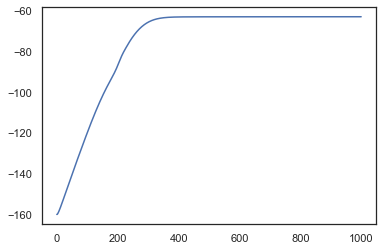

In [70]:
# ELBO
plt.plot(logf)

In [71]:
mean, var = m.predict_f(X_train)

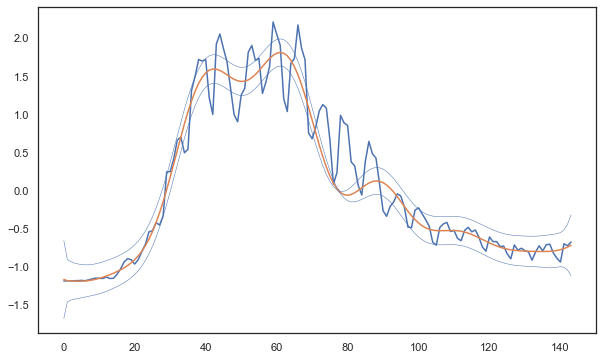

In [72]:
plt.figure(figsize=(10,6))
plt.plot(y_train)
plt.plot(mean)
plt.plot(mean + 2 * np.sqrt(var), "C0", lw=0.5)
plt.plot(mean - 2 * np.sqrt(var), "C0", lw=0.5)

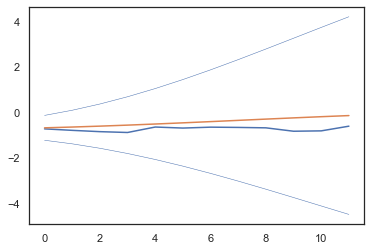

In [73]:
# The test UK data are

mean_test, var_test = m.predict_f(X_test)

plt.plot(y_test)
plt.plot(mean_test)
plt.plot(mean_test + 2 * np.sqrt(var_test), "C0", lw=0.5)
plt.plot(mean_test - 2 * np.sqrt(var_test), "C0", lw=0.5)

In [76]:
var_test

<tf.Tensor: shape=(12, 1), dtype=float64, numpy=
array([[0.07470408],
       [0.13632142],
       [0.23665321],
       [0.38911023],
       [0.60772834],
       [0.90592662],
       [1.2951239 ],
       [1.7833945 ],
       [2.37435312],
       [3.06643498],
       [3.85268367],
       [4.72108654]])>

### Alternative Model

In [ ]:
final_data_uk

In [77]:
final_data_uk["WEEKDAY"] = final_data_uk["WEEKDAY"].astype("float64")
y = final_data_uk["Confirmed cases"].to_numpy()
X = final_data_uk[["Date_number", "WEEKDAY", "HOME", "WORK", "OTHER"]].to_numpy()

y = preprocessing.scale(y)
X = preprocessing.scale(X)

split = 144

y_train = y[:split]
y_test = y[split:]

X_train = X[:split]
X_test = X[split:]

y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))

In [78]:
k = gpflow.kernels.Matern52()

SE = gpflow.kernels.SquaredExponential()
LIN = gpflow.kernels.Linear()
RQ = gpflow.kernels.RationalQuadratic()
k = SE*LIN*RQ

print_summary(k)

╒═════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                            │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ Product.kernels[0].variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Product.kernels[0].lengthscales │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Product.kernels[1].variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────────────┼───────────┼─────────────┼─────────┼─

In [79]:
m = gpflow.models.VGP(
    (X_train, y_train), likelihood=gpflow.likelihoods.Gaussian(), kernel=k)

natgrad = NaturalGradient(gamma=1.0)
adam = tf.optimizers.Adam(0.01)

set_trainable(m.q_mu, False)
set_trainable(m.q_sqrt, False)

logf = []

for _ in range(ci_niter(1000)):
    adam.minimize(m.training_loss, m.trainable_variables)
    natgrad.minimize(m.training_loss, [(m.q_mu, m.q_sqrt)])   
    logf.append(m.elbo())

In [80]:
mean, var = m.predict_f(X_train)

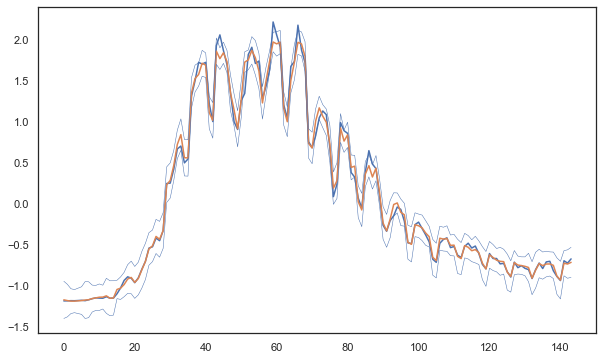

In [81]:
plt.figure(figsize=(10,6))
plt.plot(y_train)
plt.plot(mean)
plt.plot(mean + 2 * np.sqrt(var), "C0", lw=0.5)
plt.plot(mean - 2 * np.sqrt(var), "C0", lw=0.5)

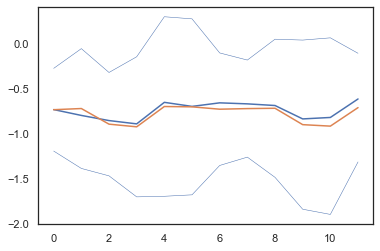

In [83]:
# The test UK data are

mean_test, var_test = m.predict_f(X_test)

plt.plot(y_test)
plt.plot(mean_test)
plt.plot(mean_test + 2 * np.sqrt(var_test), "C0", lw=0.5)
plt.plot(mean_test - 2 * np.sqrt(var_test), "C0", lw=0.5)

In [84]:
var_test

<tf.Tensor: shape=(12, 1), dtype=float64, numpy=
array([[0.05307735],
       [0.11148958],
       [0.08303029],
       [0.15247004],
       [0.25038396],
       [0.24055258],
       [0.09838686],
       [0.07319842],
       [0.14823889],
       [0.22224733],
       [0.2422283 ],
       [0.09164884]])>